In [45]:
import requests
import folium
from folium.plugins import MarkerCluster
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import re
import datetime
import qgrid
import random
 
#______________________________________scraper le site monster et recuperer les informations qui nous interessent______________________
 
monster_data = {"Categorie":[],
                 "intitule de l'offre": [],
                 "nom_entreprise": [],
                 "Lieu": [],
                 "DATE": [],
                 "Lien": [],
                 "Latitude":[],
                 "Longitude":[],
                 "description":[],
                 "Type-contrat":[],
                 "langage_prog":[],
                 "langage2":[],
                 "langage3":[],
                 "langage4":[] }  
 
jod_d = ["data-analyst", "data-scientist", "data-ingenieur"]
for d in jod_d:
    url = f'https://www.monster.fr/emploi/recherche/?q={d}&where=Auvergne__2DRh__C3__B4ne__2DAlpes&cy=fr&stpage=1&page=9'  
    r = requests.get(url, auth=('user', 'pass'))
    r.headers['content-type']
    soup = BeautifulSoup(r.text, 'html.parser')
    intitulé = soup.find_all("h2", class_ = "title")
    entreprise= soup.find_all("div", class_ = "company")
    lien = soup.find_all("h2", class_ = "title")
    Lieu = soup.find_all("div", class_ = "location")
    lieu = soup.find_all("span", class_ = "mux-tooltip multi-loc-link")
    geometry =soup.find_all('a',{"data-bypass":"true"})
    for i in range(len(soup.find_all("div", {"class":"summary"}))-1):
        monster_data["Categorie"].append(d)
        monster_data["intitule de l'offre"].append(intitulé[i].text.replace("\n", "").strip())        
        monster_data["Lien"].append(lien[i].find('a').get('href'))      
        monster_data["nom_entreprise"].append(entreprise[i].text.replace("\n", " ").strip())      
        monster_data["Lieu"].append(Lieu[i+1].text.replace("\n", "").strip().replace(", Auvergne-Rhône-Alpes", " "))
        monster_data['Latitude'].append(str(geometry[i].get('data-m_impr_j_lat')))
        monster_data['Longitude'].append(str(geometry[i].get('data-m_impr_j_long')))
        regex = re.compile("\d{4}-\d{2}-\d{2}")
        date = regex.findall(str(geometry[i]))
        monster_data["DATE"].append(date[0] if len(date)>0 else np.nan)
        url2 = lien[i].find('a').get('href')
        r = requests.get(url2)
        soupet = BeautifulSoup(r.text, 'html.parser')
        descript = soupet.find("div", class_ = "job-description")
        if  descript is None:
            monster_data["description"].append(None)
        else:
            description = descript.text
            monster_data["description"].append(description)
        regex = re.compile("((CDI)|(CDD)|(stage))")
        type_contrat = re.findall(regex, str(monster_data["description"][i]))
        if len(type_contrat)>0:
            monster_data["Type-contrat"].append(list(type_contrat)[0][0])
        else:
            monster_data["Type-contrat"].append(np.nan)
        pattern1 = re.compile(r'(?P<SQL>[Ss][Qq][Ll])')
        pattern2 = re.compile(r'(?P<Python>[Pp][Yy][Tt][Hh][Oo][Nn])')
        pattern3 = re.compile(r'(?P<Scala>[Ss][Cc][Aa][Ll][Aa])')
        pattern4 = re.compile(r'(?P<Java>[Jj][Aa][Vv][Aa])')
        match1 = re.search(pattern1,description)
        match2 = re.search(pattern2,description)
        match3 = re.search(pattern3,description)
        match4 = re.search(pattern4,description)
        if match1 is None:
            monster_data["langage_prog"].append(np.nan)    
        else:
            monster_data["langage_prog"].append(match1.group())
        if match2 is None:
            monster_data["langage2"].append(np.nan)
        else:  
            monster_data["langage2"].append(match2.group())    
        if match3 is None:
            monster_data["langage3"].append(np.nan)
        else:    
            monster_data["langage3"].append(match3.group())
        if match4 is None:
            monster_data["langage4"].append(np.nan)
        else:  
            monster_data["langage4"].append(match4.group())




In [46]:
def grid_m():
    df = pd.DataFrame(monster_data)
    df1 = df.replace(np.nan, "").drop_duplicates(subset=['DATE', 'Lien', "intitule de l'offre"], keep='last')
    df1.to_csv('monstre.csv', index = False)

    for row in df1.iterrows():
        row[1]['langage_prog'] =str(row[1]['langage_prog'])+"-"+str(row[1]['langage2'])+"-"+str(row[1]['langage3'])+"-"+str(row[1]['langage4'])
    df1 = df1.drop(["langage4", "langage2", "langage3", "description"], axis = 1) 
    df_qgrid = qgrid.show_grid(df1, show_toolbar=True)
    
    return df_qgrid
grid_m()

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

In [47]:
csv = pd.read_csv('monstre.csv')
csv

,Categorie,intitule de l'offre,nom_entreprise,Lieu,DATE,Lien,Latitude,Longitude,description,Type-contrat,langage_prog,langage2,langage3,langage4
0,data-analyst,Data Analyst H/F,EPSA TAX,Lyon,2021-02-26,https://offre-demploi.monster.fr/data-analyst-...,45.7604,4.84889999999999,DescriptionEPSA Tax est un cabinet de conseil ...,stage,SQL,Python,NaN,NaN
1,data-analyst,Alternance - Master Data analyst (H/F),ABB FRANCE,Beynost,2021-02-23,https://offre-demploi.monster.fr/alternance-ma...,45.8397,5.00470000000001,DescriptionAlternance - Master Data analyst (H...,CDI,NaN,NaN,NaN,NaN
2,data-analyst,Business intelligence ou Data Analyst (H/F),Innovallée,Meylan,2021-02-16,https://offre-demploi.monster.fr/business-inte...,45.2178,5.77959999999999,DescriptionTalents\n \n Business intelligence ...,stage,NaN,NaN,NaN,NaN
3,data-analyst,Stage - Data Analyst Junior - H/F,Photoweb,Saint-Egrève,2021-02-11,https://offre-demploi.monster.fr/stage-data-an...,45.2712,5.6782,"DescriptionEn tant que Data Analyst Junior, no...",stage,SQL,NaN,NaN,NaN
4,data-analyst,Data Analyst Junior (H/F) Mobile Gaming [CDI] ...,Paris & Co - Paris et Compagnie,Lyon,2021-02-04,https://offre-demploi.monster.fr/data-analyst-...,45.7674,4.83430000000001,DescriptionData Analyst Junior (H/F) Mobile Ga...,CDI,SQL,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114,data-ingenieur,SRE Engineer /Ops (H/F),Coservit,Grenoble,2021-02-19,https://offre-demploi.monster.fr/sre-engineer-...,45.7363,4.86969999999999,DescriptionSRE Engineer /Ops\n \n PUBLISHED ON...,NaN,sql,Python,scala,NaN
115,data-ingenieur,Stage - Ingenieur Travaux Infrastructures Liné...,Ingérop,Grenoble,2021-02-27,https://offre-demploi.monster.fr/stage-ingenie...,45.7674,4.83430000000001,DescriptionOuvrir le sous-menu\n \n Fermer le ...,stage,NaN,NaN,NaN,NaN
116,data-ingenieur,Ingénieur Système & Réseau (H/F),Rezopole,Caluire-et-Cuire,2020-12-14,https://offre-demploi.monster.fr/ingénieur-sys...,45.1942,5.73159999999999,DescriptionIngénieur Système & Réseau (H/F) \n...,NaN,NaN,NaN,NaN,NaN
117,data-ingenieur,Ingénieur Systèmes et Réseaux - ★★★★★ (H/F),Soluxan,Lyon,2020-10-29,https://offre-demploi.monster.fr/ingénieur-sys...,45.1942,5.73159999999999,DescriptionPoste disponible en CDI ou Freelanc...,NaN,SQL,NaN,NaN,Java


NameError: name 'plot' is not defined

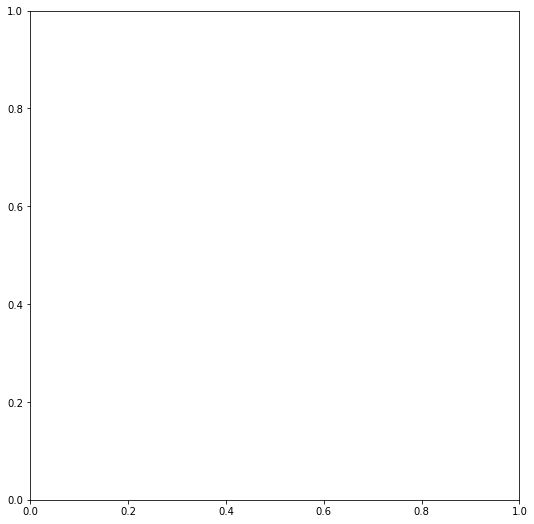

In [48]:

#__________________________Matplotlib : Pie pour les metiers de la date sur monster_______________-
 
def job_m():
    df = pd.read_csv('monster.csv')
    fig, ax = plt.subplots(figsize=(15, 9), subplot_kw=dict(aspect="equal"))
    cat = df["Categorie"].value_counts()
    cat = cat.astype(str)
    data = [float(x.split()[0]) for x in cat]
    Métiers =["developpeur-data", "data-ingenieur", "data-analyst", "data-scientist"]
    return plot()
job_m()

In [ ]:


def maps():
    long = 5.4502821
    lat = 45.1695797
    ARA = (lat, long)
    carte = folium.Map(location=ARA, zoom_start=9, tiles='OpenStreetMap')
    marker_cluster = MarkerCluster().add_to(carte)
    offres = pd.read_csv("monster.csv")
    df = offres.fillna(0)
    for i , row in df.iterrows():
        folium.Marker(location = [row['latitude'], row['longitude']], popup = (row["lien"], row["Categorie"],row["Type-contrat"])).add_to(marker_cluster)

    marker_cluster.add_to(carte)

    folium.LayerControl().add_to(carte) 
    return carte

maps()

In [ ]:
def func(pct, allvals):
        absolute = int(pct/100.*np.sum(allvals) + 1)
        return "{:.1f}%\n({:d} offres)".format(pct, absolute)
    wedges, texts, autotexts = ax.pie(data, autopct=lambda pct: func(pct, data),textprops=dict(color="black"))
    ax.legend(wedges, Métiers,
              title="Métiers",
              loc="center left",
              bbox_to_anchor=(1, 0, 0.5, 1))

    plt.setp(autotexts, size=10, weight="bold")

    ax.set_title("Repartition des métiers de la Data par rapport aux offres sur Monster")

    return plt.show()
    

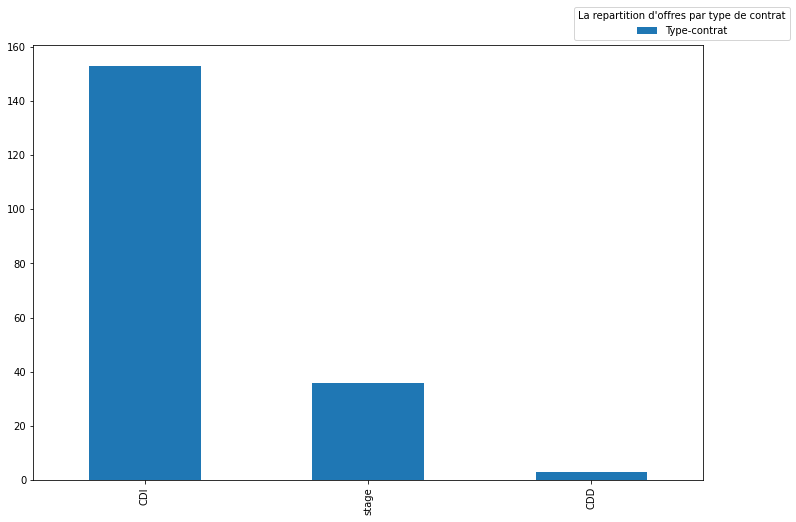

In [5]:

def contrat():
    data =  pd.read_csv("monster.csv")
    cat = data["Type-contrat"].value_counts()
    cat.plot(kind="bar",stacked=True,figsize=(12,8))
    plt.legend(title = "La repartition d'offres par type de contrat", loc="lower left",bbox_to_anchor=(0.8,1.0))
    return 
contrat()
